<a href="https://colab.research.google.com/github/jasreman8/Single-Agent-Systems/blob/main/Self_Reflective_RAG_Agent_Using_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

- Construct Agentic Workflows: Understand how to build multi-step, stateful agent internal mechanisms using LangGraph's StateGraph, nodes, and edges.
- Implement Custom RAG Logic: Learn to integrate core RAG components (retriever, generator) with custom enhancements like relevance checking and query rewriting within a graph structure.
- Control Agent Flow: Utilize conditional edges (`add_conditional_edges`) based on tool usage (`tools_condition`) and custom logic (LLM-based relevance grading) to direct the agent's execution path.

# Setup

In [1]:
!pip install -q openai==1.66.3 \
                langchain==0.3.20 \
                langchain-openai==0.3.9 \
                langchain-community==0.3.19 \
                langchain-chroma==0.2.2 \
                langgraph==0.3.21 \
                grandalf==0.8 \
                chromadb==0.6.3

In [2]:
import os
import chromadb

from typing import Annotated, Sequence, Literal, TypedDict

from langchain import hub

from pydantic import BaseModel, Field

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langchain.tools.retriever import create_retriever_tool

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph.message import add_messages

from google.colab import userdata

#Vector databases store embeddings that capture semantic meaning, unlike relational databases that store structured data.

In [3]:
# Hide warnings/logs from Chroma
# This code mutes the following telemetry error in ChromaDB:
# ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
import logging
logging.getLogger("chromadb").setLevel(logging.CRITICAL)

In [4]:
openai_api_key = userdata.get('OPEN_API_KEY')

llm = ChatOpenAI(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='gpt-4o-mini',
    temperature=0
)
# We are building a language model for reasoning and text-generation.  (Temp = 0 --> consistent and deterministic responses and not creative)

embedding_model = OpenAIEmbeddings(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model="text-embedding-3-small"
)
# We are building an embedding model for understanding the semantic meaning of text.

# Business Scenario

A RAG agent is highly useful for internal corporate knowledge base querying where accuracy and relevance are paramount. Imagine employees needing specific information from extensive technical manuals, financial reports (like the Tesla 10Ks used here), or HR policy documents.

- **Problem:** Simple keyword searches or basic RAG might return irrelevant sections if the employee's query is slightly ambiguous or doesn't use the exact terminology found in the documents. This leads to wasted time and potentially incorrect information.

- **Solution:** This agentic workflow ensures that retrieved document sections are first checked for relevance against the user's actual question. If relevant, a precise answer is generated. If not, the agent attempts to rewrite the query to better capture the user's intent and retries the retrieval process. This significantly increases the reliability and accuracy of answers derived from the company's specific knowledge sources.

# Implementation Roadmap

The goal is to build a RAG agent where the internal decision-making process is explicitly defined using LangGraph, providing fine-grained control over the workflow, particularly regarding context relevance.

1. Component Preparation:

    - Initialize core AI components: A language model (LLM) for reasoning and text generation, and an embedding model for understanding text semantics.

    - Establish connection to the knowledge source: Set up access to the vector database containing the relevant document embeddings (e.g., Tesla 10K filings).

    - Define the retrieval capability: Create a retriever mechanism configured to search the vector database based on semantic similarity. Package this retriever as a distinct "tool" the agent can choose to use.

2. Workflow State Definition:

    - Design a structure to hold the state of the conversation as it progresses. This state must primarily track the sequence of interactions (messages) between the user and the agent, including intermediate results like tool outputs. Ensure new messages are appended to maintain history.

3. Core Workflow Structure (Conceptual Graph):

    - Define the key processing steps (conceptual "nodes") and the transitions (conceptual "edges") between them.

4. Planning / Decision Step:

    - Implement the initial processing step after receiving input.

    - This step uses the LLM, informed about the available retrieval tool, to analyze the latest user query within the context of the conversation history.

    - The LLM's primary goal here is to decide if using the retrieval tool is the necessary next action to address the query.

    - The output of this step should indicate the chosen action (e.g., signal intent to use the tool, or provide a direct response).

5. Tool Execution Branching:

    - Implement logic to check the outcome of the Planning step.

    - If the Planning step signaled the intent to use the retrieval tool, direct the workflow to the Retrieval step.

    - If no tool use was intended (e.g., the LLM generated a direct answer), terminate the workflow.

6. Document Retrieval Step:

    - Implement the step that executes the retrieval tool/capability defined in Step 1.

    - Capture the documents returned by the retriever and add them (e.g., as a specific message type) to the workflow state.

7. Relevance Assessment Step (Decision Point):

    - Implement a critical checkpoint immediately after retrieval.

    - This step uses the LLM to compare the content of the just-retrieved documents against the user's original query (preserved in the state).

    - The goal is to determine if the retrieved information is semantically relevant to answering the question.

    - The output must be a clear signal: "Relevant" or "Not Relevant".

8. Conditional Flow based on Relevance:

    - Implement transition logic based on the Relevance Assessment outcome:

        - If "Relevant," direct the workflow to the Final Answer Generation step.

        - If "Not Relevant," direct the workflow to the Query Rewriting step.

9. Final Answer Generation Step:

    - Implement the step responsible for synthesizing the final response.

    - This step uses the LLM, providing it with the validated relevant documents from the state and the original user query.

    - Generate the final answer and add it to the workflow state.

    - Terminate the workflow successfully.

10. Query Rewriting Step:

    - Implement the self-correction mechanism.

    - This step uses the LLM, instructing it to rephrase or clarify the original user query based on the knowledge that the previous retrieval attempt failed to find relevant information.

    - The output should be the rewritten query. Update the workflow state to reflect this new query (potentially replacing or marking the old one).

    - Direct the workflow to loop back to the Planning / Decision Step (Step 4) to process the rewritten query.

# Vector Store Setup

In [5]:
# ! unzip tesla_db.zip

In [6]:
chromadb_client = chromadb.PersistentClient(
    path='./tesla_db'
)

In [7]:
tesla_10k_collection = 'tesla-10k-2019-to-2023'

In [8]:
try:
    chromadb_client.get_collection(tesla_10k_collection)
    print(f"Collection '{tesla_10k_collection}' found.")
except Exception:
    print(f"Warning: Collection '{tesla_10k_collection}' not found in '{chromadb_client.path}'. Ensure it exists and contains data.")

Collection 'tesla-10k-2019-to-2023' found.


In [9]:
vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    embedding_function=embedding_model,
    client=chromadb_client,
)

In the above code block:

- `! unzip tesla_db.zip`: Unzips a local file containing the pre-built Chroma database files (this assumes `tesla_db.zip` exists in the Colab environment).
- `chromadb.PersistentClient`: Creates a client connection to the persistent Chroma database stored in the `./tesla_db` directory.
- Checks if the target collection (`tesla_10k_collection`) exists within the database using `get_collection` and prints a status message.
- `Chroma(...)`: Creates a LangChain Chroma vector store object, linking it to the existing collection name, the embedding model, and the ChromaDB client.

In [10]:
retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)
# This retriever will provide FIVE most semantically similar document chunks to any query that we provide.

In [11]:
retriever_tool = create_retriever_tool(
    retriever, # The retriever is now wrapped into a tool with a very specific description that guides the agent's behavior.
    "retrieve_tesla_10k_documents",
    """
    Search and return information mentioned in Tesla 10K documents from 2019 to 2023.
    Use this tool ONLY to find specific financial figures, operational details, risks,
    or other factual data directly reported in Tesla's 10-K filings.
    Do NOT use this tool for general knowledge questions about Tesla.
    """
)

tools = [retriever_tool]

In the above code block:

- `vectorstore_persisted.as_retriever(...)`: Creates a LangChain retriever object from the vector store. It's configured for similarity search and to retrieve the top 5 (k=5) most similar documents.
- `create_retriever_tool(...)`: Wraps the retriever into a LangChain Tool. This gives it a name (`retrieve_tesla_10k_documents`) and a description, which the LLM uses to understand when and how to use this tool. The description guides the LLM to use it only for specific factual queries from the 10-K documents.
- `tools = [retriever_tool]`: Defines a list containing the tool(s) the agent can use.

# Agent State Definition

 - The agent stage structure defines the sequence in which an agent plans, executes, and reflects within its workflow. Common stages include planning, tool execution, reasoning, reflection, and response.

In [12]:
class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

# This class forms the foundation of our entire agent's memory system.

In the above code block:
- `class AgentState(TypedDict): ...`: Defines the structure of the data that will persist and be passed between nodes in the graph.

- `messages: Annotated[Sequence[BaseMessage], add_messages]`: Defines a key messages which holds a sequence of LangChain `BaseMessage` objects. The Annotated type hint with `add_messages` tells LangGraph that whenever a node returns a list of messages for this key, they should be appended to the existing list in the state, rather than replacing it.

# Pre-configured LLM and Chains

In the code blocks below, we define a series of chains that handle LLM call executions to grade document relevance, rewrite queries and generate RAG outputs.

Specifically:
- `llm_with_tools = llm.bind_tools(tools):` Creates a version of the LLM that is aware of the available tools. This is used by the `plan` node so the LLM can decide to call the `retriever_tool`.
- `rewrite_prompt_template`, `rewrite_chain`: Defines the prompt and chain specifically for rewriting the user's query if the initial retrieval fails the relevance check. It uses the base llm and a `StrOutputParser` to get just the rewritten text.

- `rag_prompt_template`, `rag_chain`: Defines the prompt (pulled from LangChain Hub) and chain for generating the final answer, taking context (retrieved documents) and the question as input. It uses the base llm and `StrOutputParser`.

- `GradeDocuments`, `structured_llm_grader`, `grade_prompt_template`, `grading_chain`: Defines the components for the relevance check. `GradeDocuments` is a Pydantic model defining the desired JSON output structure ('yes'/'no'). `structured_llm_grader` is an LLM configured to output data matching this structure. The grade_prompt_template instructs the grader, and the `grading_chain` combines the prompt and the structured LLM. Defining these globally makes the grade_documents edge function cleaner and more efficient.

In [13]:
llm_with_tools = llm.bind_tools(tools)

# A language model predicts the next token based on probability distributions.
# Modern LLMs like GPT are transformer-based and trained on trillions of tokens.

In [14]:
# Chain for query rewriting
rewrite_prompt_template = PromptTemplate(
    template="""You are a query transformation assistant. Your task is to rewrite the user's original question \
based on the fact that the initial retrieval attempt failed to find relevant documents. \
Focus on clarifying the intent or broadening the scope slightly, while staying true to the core request. \
\nOriginal Question: {question}\
\nProvide ONLY the rewritten question:""",
    input_variables=["question"],
)

rewrite_chain = rewrite_prompt_template | llm | StrOutputParser()

In [15]:
# Chain for final answer generation
rag_prompt_template = hub.pull("rlm/rag-prompt")
# Pulling a pre-built prompt template from LangChain Hub that's specifically designed for RAG tasks.

rag_chain = rag_prompt_template | llm | StrOutputParser()

/usr/local/lib/python3.12/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


 - Document structure ensures organized retrieval and chunking of data. Chunks with metadata (source, timestamp, tags) improve search and context injection.

In [16]:
# Pydantic model for the grading output
class GradeDocuments(BaseModel):
    """Binary score for relevance check."""
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

# LLM with structured output for grading
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Chain for grading documents
grade_prompt_template = PromptTemplate(
    template="""You are a grader assessing relevance of retrieved documents to a user question.
Here are the retrieved documents:\n\n{context}\n\n
Here is the user question: {question}
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
    input_variables=["context", "question"],
)

grading_chain = grade_prompt_template | structured_llm_grader

# Node Functions

In this section, we implement the key functions (`plan`, `generate` and `rewrite`) that make up the internal wiring of the agent.

- These Python functions define the actions performed at specific points (nodes) in the graph.
- Each function takes the current state (an AgentState dictionary) as input.
- `plan`: Uses `llm_with_tools` to decide the next action based on the messages in the state. Returns the `AIMessage` (which might include a tool call) to be added to the state.

- `rewrite`: Extracts the original question, uses the `rewrite_chain` to get a new question, and returns a new HumanMessage containing only the rewritten query. This resets the context for the next planning step.

- `generate`: Extracts the question and the retrieved document content (from the last `ToolMessage`), uses the `rag_chain` to generate the final answer, and returns it as an `AIMessage`.

- Each node returns a dictionary mapping state keys (only messages here) to the new value(s) to be merged into the state according to the `AgentState` annotations.

 A retriever is used to fetch relevant documents or data from a knowledge base. It works with vector databases to return the most contextually relevant information.

In [17]:
def plan(state: AgentState):
    """
    Invokes the retriever to retrieve documents based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---PLAN RETRIEVAL---")
    messages = state["messages"]

    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}

# Agent's central intelligence hub.

In [18]:
def rewrite(state: AgentState):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---REWRITE QUERY---")
    messages = state["messages"]
    current_question = messages[0].content

    rewritten_question = rewrite_chain.invoke({"question": current_question})

    return {"messages": [HumanMessage(content=rewritten_question)]}

# Query improvement mechanism.

In [19]:
def generate(state: AgentState):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE ANSWER---")
    messages = state["messages"]
    question = messages[0].content

    last_message = messages[-1]

    docs_content = last_message.content

    # Use the globally defined RAG chain
    response = rag_chain.invoke({"context": docs_content, "question": question})
    # The response gets formatted as an AI message, and then it's also added to the conversation state.

    # Return the response as an AIMessage
    return {"messages": [AIMessage(content=response)]}

# Edge Function

The function defined in the code block below implements the logic for a conditional edge. It determines which node the graph should transition to after the retrieve node completes.

- It takes the current state as input.
- It extracts the question and the retrieved documents' content.
- It uses the globally defined grading_chain to assess relevance.
- It returns a string ("generate" or "rewrite") which corresponds to the key in the conditional edge mapping defined later, thus directing the flow to the appropriate next node. Includes basic error handling.

Edge functions in LangGraph define the connections (edges) between nodes in the workflow graph/ They help decide which node to run next based on conditions or outputs of the previous step.

In [20]:
# Decision between rewriting the query and generating the final answer

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs_content = last_message.content

    # Use the globally defined grading chain
    try:
        scored_result = grading_chain.invoke({"question": question, "context": docs_content})
        score = scored_result.binary_score.lower()
        print(f"--- Relevance Score: {score} ---")
        if score == "yes":
            print("---DECISION: DOCS RELEVANT---")
            return "generate"
        else:
            print("---DECISION: DOCS NOT RELEVANT---")
            return "rewrite"
    except Exception as e:
        print(f"--- Error during grading: {e} ---")
        return "rewrite" # Default to rewrite on grading error

# Graph Construction

In the code block below, we implement an execution graph depicting the internal workflow of the RAG agent.

Specifically:

- `workflow = StateGraph(AgentState)`: Initializes a state machine graph configured to manage the AgentState.
- `workflow.add_node(...)`: Adds the defined functions (plan, rewrite, generate) and the pre-built ToolNode (retrieve) as nodes in the graph.
- `workflow.add_edge(START, "plan")`: Sets the entry point of the graph to the plan node.
- `workflow.add_conditional_edges("plan", tools_condition, ...)`: Defines the transition from the plan node. It uses the `tools_condition` function to check the output of plan. If `tools_condition` detects a tool call, flow goes to the "retrieve" node; otherwise, flow goes to END.
- `workflow.add_conditional_edges("retrieve", grade_documents, ...)`: Defines the transition from the retrieve node using our custom grade_documents function. Based on the return value ("generate" or "rewrite"), it routes to the respective node.
- `workflow.add_edge("rewrite", "plan")`: Defines a fixed edge causing the workflow to loop back to the plan node after a query rewrite.
- `workflow.add_edge("generate", END)`: Defines a fixed edge causing the workflow to terminate after generating the final answer.

In [21]:
# Define a new graph
workflow = StateGraph(AgentState)

 - Agent stage structure defines the phases an agent goes through while reasoning, typically including planning (deciding the next step), action (invoking a tool or function), observation (receiving results), and reflection (rethinking or updating the plan if needed).

In [22]:
# Define the nodes we will cycle between
workflow.add_node("plan", plan)  # central planner
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant

# Call agent node to decide to retrieve or not

workflow.add_edge(START, "plan")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "plan",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END
    }
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents
)

workflow.add_edge("rewrite", "plan")
workflow.add_edge("generate", END)

# Graph Compilation and Invocation

In [23]:
agent_workflow = workflow.compile()

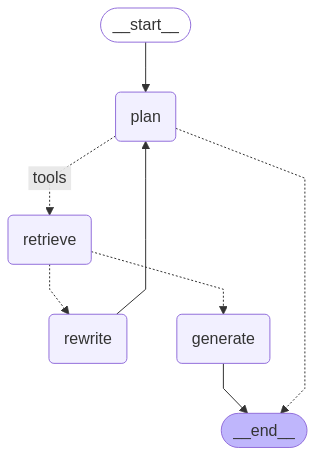

The below code runs the compiled workflow, starting with the initial state containing the user query formatted as a `HumanMessage`. The workflow executes node by node according to the defined edges until it reaches `END`. The final state is returned in result.

Let us look at an example of the internal workings of this agent in action with a few examples.

**Example 1**

In [24]:
user_query = "what was the revenue from automobile operations in 2022?"
result = agent_workflow.invoke({"messages": [HumanMessage(content=user_query)]})

---PLAN RETRIEVAL---
---CHECK RELEVANCE---
--- Relevance Score: yes ---
---DECISION: DOCS RELEVANT---
---GENERATE ANSWER---


In [25]:
print(result['messages'][-1].content)

The total revenue from automobile operations in 2022 was $82,419 million. This includes automotive sales, regulatory credits, and leasing revenues.


**Example 2**

In [26]:
user_query = "Were there specific mentions of Cybertruck manufacturing challenges in the 2022 10-K risk factors?"
result = agent_workflow.invoke({"messages": [HumanMessage(content=user_query)]})

---PLAN RETRIEVAL---
---CHECK RELEVANCE---
--- Relevance Score: yes ---
---DECISION: DOCS RELEVANT---
---GENERATE ANSWER---


In [27]:
print(result['messages'][-1].content)

Yes, the 2022 10-K risk factors specifically mentioned potential delays and complications in launching and ramping production of the Cybertruck, along with other new vehicles. These challenges could arise from design, manufacturing, and regulatory issues. The report highlighted that such delays could adversely affect the company's business and financial condition.


**Example 3**

Let us look at an example where the tool execution should potentially be skipped. This will test the edge case where the conditional edge between `plan` and `END` is activated.

In [28]:
user_query = "Tell me about the design philosophy behind the Cybertruck."
result = agent_workflow.invoke({"messages": [HumanMessage(content=user_query)]})

---PLAN RETRIEVAL---


In [29]:
print(result['messages'][-1].content)

The design philosophy behind the Tesla Cybertruck is characterized by its bold, unconventional aesthetics and a focus on utility, durability, and performance. Here are some key aspects of its design philosophy:

1. **Futuristic Aesthetics**: The Cybertruck features a geometric, angular design that departs from traditional truck shapes. This design is intended to evoke a sense of the future and innovation.

2. **Material Choice**: The body of the Cybertruck is made from ultra-hard 30X cold-rolled stainless steel, which is intended to provide superior durability and resistance to dents, corrosion, and damage. This choice reflects a commitment to building a vehicle that can withstand tough conditions.

3. **Armor Glass**: The Cybertruck is equipped with Tesla's "armor glass," which is designed to be shatter-resistant. This feature aligns with the overall philosophy of creating a robust and resilient vehicle.

4. **Functionality and Versatility**: The design emphasizes utility, with a spac

To understand why there was no relevance check, look closely at the retriever_tool description:

```
"""
Search and return information mentioned in Tesla 10K documents from 2019 to 2023.
Use this tool ONLY to find specific financial figures, operational details, risks,
or other factual data directly reported in Tesla's 10-K filings.
Do NOT use this tool for general knowledge questions about Tesla.
"""
```

So why wasn't relevance check triggered here?

- The LLM (gpt-4o-mini) analyzes the query "Tell me about the design philosophy behind the Cybertruck." against the tool description. It correctly determines that "design philosophy" is likely a general knowledge question about Tesla/Cybertruck, not the specific financial/operational/risk data found in 10-K filings that the tool description explicitly restricts itself to. The instruction "Do NOT use this tool for general knowledge questions about Tesla" is crucial here.

- Skipping the Tool: Because the query doesn't match the tool's designated purpose, the LLM decides not to invoke the retriever_tool. Instead of outputting a message with a tool_call, it outputs a standard `AIMessage` containing the answer based on its own pre-trained general knowledge.

- Graph Flow (`tools_condition`): The plan node returns this direct AIMessage. The `tools_condition` edge checks this message. Since there's no `tool_call` present, the condition evaluates to `END`.

- Bypassing Retrieval and Relevance: The workflow transitions directly from plan to `END`, completely bypassing the retrieve node and therefore also the `grade_documents` relevance check node.

The above example underscores the importance of tool descriptions in guiding the behavior of the agent.